## Project Machine Learning - Paolo Rinaldi

### Import the essential libraries



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from imblearn.over_sampling import RandomOverSampler
from matplotlib.cbook import boxplot_stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans, DBSCAN
from safeaipackage import core, check_explainability, check_fairness, check_robustness
from sklearn.feature_selection import (
    VarianceThreshold,
    mutual_info_classif)
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

### Import of Data Set

In [2]:
df = pd.read_csv('dataset_1_lendingclub.csv')

In [3]:
# Overview 
print(df.shape)       
print(df.info())     
print(df.head())

(2260701, 151)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     

### Mapping Fully Paid and Charged Off

In [4]:
keep_status = ['Fully Paid', 'Charged Off']
df_mapping = df[df['loan_status'].isin(keep_status)].copy()
mapping = {
    'Fully Paid': 1,
    'Charged Off': 0,
}
df_mapping['loan_status'] = df_mapping['loan_status'].map(mapping)

### Choosing which variables put in the DataFrame

In [5]:
#1 Define and keep only the ex-ante columns
to_exclude_prefix = [
    'last_', 'total_rec_', 'recoveries', 'total_pymnt', 'collection_recovery_fee'
]
col_keep = [
    c for c in df_mapping.columns
    if not any(c.startswith(pref) for pref in to_exclude_prefix)
]
df_mapping = df_mapping[col_keep]

#2 Remove columns with more than 50% missing values
missing_frac = df_mapping.isnull().mean()
df_mapping = df_mapping.loc[:, missing_frac < 0.5]

#3 Separate numerical and categorical feature
num_all = df_mapping.select_dtypes(include=[np.number]).columns.tolist()
cat_all = df_mapping.select_dtypes(include=['object','category']).columns.tolist()

#4 Apply VarianceThreshold on numerical features (threshold = 0.01)
sel_var = VarianceThreshold(threshold=0.01)
sel_var.fit(df_mapping[num_all].fillna(0))
num_var = [c for c, keep in zip(num_all, sel_var.get_support()) if keep]

#5 Compute linear correlation with the target (|ρ| > 0.1)
if 'loan_status' in df_mapping.columns:
    corr = df_mapping[num_var].corrwith(df_mapping['loan_status']).abs()
    num_corr = corr[corr > 0.1].index.tolist()
else:
    num_corr = num_var

#6 Calculate mutual information for both numerical and categorical features (after preliminary encoding)
X_temp = df_mapping[num_corr + cat_all].copy()
X_temp[cat_all] = X_temp[cat_all].astype(str).fillna('missing')
y_temp = df_mapping['loan_status'] if 'loan_status' in df_mapping.columns else None

enc = OrdinalEncoder()
X_temp[cat_all] = enc.fit_transform(X_temp[cat_all])

mi = mutual_info_classif(X_temp, y_temp, discrete_features='auto')
mi_series = pd.Series(mi, index=X_temp.columns).sort_values(ascending=False)
keep_mi = mi_series.head(20).index.tolist()

#7 Select the final feature set (excluding the target)
features = [c for c in keep_mi if c != 'loan_status']

#8 Create the filtered DataFrame
df_filtered = df_mapping[features + (['loan_status'] if 'loan_status' in df_mapping.columns else [])]


In [6]:
pd.set_option("display.max_rows", None)
print(df_filtered.columns.tolist())

['initial_list_status', 'home_ownership', 'verification_status', 'grade', 'purpose', 'title', 'sub_grade', 'term', 'debt_settlement_flag', 'int_rate', 'fico_range_high', 'fico_range_low', 'emp_length', 'emp_title', 'addr_state', 'issue_d', 'id', 'url', 'zip_code', 'loan_status']


In [7]:
# List of columns to drop and add
columns_to_drop = ['initial_list_status', 'title', 'sub_grade', 'emp_title', 'addr_state', 'issue_d', 'url', 'id', 'zip_code'] 
columns_to_add = ['annual_inc','dti','loan_amnt','open_acc','pub_rec','delinq_2yrs','inq_last_6mths', 'tot_cur_bal', 'revol_bal', 'revol_util', 'collections_12_mths_ex_med', 'mths_since_last_delinq', 'mort_acc', 'pub_rec_bankruptcies','tax_liens'] 

# Removal of columns
df_filtered = df_filtered.drop(columns=columns_to_drop)

# Addition of columns
for col in columns_to_add:
    if col in df.columns:
        df_filtered[col] = df[col]

In [8]:
pd.set_option("display.max_rows", None)
print(df_filtered.columns.tolist())

['home_ownership', 'verification_status', 'grade', 'purpose', 'term', 'debt_settlement_flag', 'int_rate', 'fico_range_high', 'fico_range_low', 'emp_length', 'loan_status', 'annual_inc', 'dti', 'loan_amnt', 'open_acc', 'pub_rec', 'delinq_2yrs', 'inq_last_6mths', 'tot_cur_bal', 'revol_bal', 'revol_util', 'collections_12_mths_ex_med', 'mths_since_last_delinq', 'mort_acc', 'pub_rec_bankruptcies', 'tax_liens']


grade
B    392741
C    381686
A    235090
D    200953
E     93650
F     32058
G      9132
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='grade'>

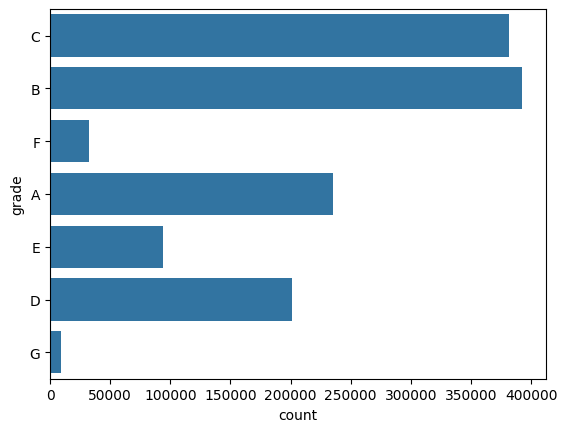

In [9]:
df_plot = df_filtered.copy()
print(df_plot["grade"].value_counts())
df_plot['grade'] = df_plot['grade'].astype(str).str.strip()
sns.countplot(df_plot["grade"])

### Mapping and Encoding

In [10]:
mapping_verification_status= {   
    'Not Verified':-1,
    'Verified':0,
    'Source Verified':1
}

df_filtered['verification_status'] = df_filtered['verification_status'].map(mapping_verification_status)

mapping_term= {   
    ' 36 months':1,
    ' 60 months':0,
}

df_filtered['term'] = df_filtered['term'].map(mapping_term)

mapping_debt_settlement_flag= {   
    'Y':0,
    'N':1,
}

df_filtered['debt_settlement_flag'] = df_filtered['debt_settlement_flag'].map(mapping_debt_settlement_flag)

mapping_debt_emp_length= {   
    '< 1 year':1,
    '1 year':2,
    '2 years':3,
    '3 years':4,
    '4 years':5,
    '5 years':6,
    '6 years':7,
    '7 years':8,
    '8 years':9,
    '9 years':10,
    '10+ years':11
}

df_filtered['emp_length'] = df_filtered['emp_length'].map(mapping_debt_emp_length)

mapping_grade = {   
    'A':6,
    'B':5,
    'C':4,
    'D':3,
    'E':2,
    'F':1,
    'G':0
}

df_filtered['grade'] = df_filtered['grade'].map(mapping_grade)

In [11]:
# Define categories to group
to_group = ['ANY', 'OTHER', 'NONE']

# Group into 'OTHERS'
df_filtered['home_ownership'] = df_filtered['home_ownership'].replace(to_group, 'OTHERS')

# Verify counts
new_counts = df_filtered['home_ownership'].value_counts()
print(new_counts)

home_ownership
MORTGAGE    665579
RENT        534421
OWN         144832
OTHERS         478
Name: count, dtype: int64


In [12]:
# Drop rows where home_ownership == 'OTHERS'
df_filtered = df_filtered[df_filtered['home_ownership'] != 'OTHERS']

# Verify counts (should no longer show 'OTHERS')
new_counts = df_filtered['home_ownership'].value_counts()
print(new_counts)

home_ownership
MORTGAGE    665579
RENT        534421
OWN         144832
Name: count, dtype: int64


In [13]:
# Define the groups as (list of original values, new label) pairs
groups = [
    (['debt_consolidation', 'credit_card'],      'consolidation'),
    (['home_improvement', 'house', 'moving'],    'home'),
    (['car', 'major_purchase'],                  'auto'),
    (['small_business', 'educational', 'renewable_energy'], 'business'),
    (['medical', 'vacation', 'wedding', 'other'], 'personal'),
]

# Loop over each group, find matching rows, and assign the new label
for values, label in groups:
    mask = df_filtered['purpose'].isin(values)        # create a boolean mask for current group
    df_filtered.loc[mask, 'purpose'] = label         # apply the new category to masked rows

# Verify the result by printing the updated value counts
new_counts = df_filtered['purpose'].value_counts()
print("The new counts for purpose are:", new_counts)


The new counts for purpose are: purpose
consolidation    1075258
personal          104735
home              104198
auto               43987
business           16654
Name: count, dtype: int64


In [14]:
print(df.shape, df_filtered.shape)      
print(df_filtered.info())    

(2260701, 151) (1344832, 26)
<class 'pandas.core.frame.DataFrame'>
Index: 1344832 entries, 0 to 2260697
Data columns (total 26 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   home_ownership              1344832 non-null  object 
 1   verification_status         1344832 non-null  int64  
 2   grade                       1344832 non-null  int64  
 3   purpose                     1344832 non-null  object 
 4   term                        1344832 non-null  int64  
 5   debt_settlement_flag        1344832 non-null  int64  
 6   int_rate                    1344832 non-null  float64
 7   fico_range_high             1344832 non-null  float64
 8   fico_range_low              1344832 non-null  float64
 9   emp_length                  1266345 non-null  float64
 10  loan_status                 1344832 non-null  int64  
 11  annual_inc                  1344832 non-null  float64
 12  dti                         1344

In [15]:
df_dup = df_filtered.drop_duplicates()                       
print("Duplicate removed, shape:", df_dup.shape)

Duplicate removed, shape: (1344832, 26)


### Handling Missing values

In [16]:
print(df_dup.isnull().sum())

home_ownership                     0
verification_status                0
grade                              0
purpose                            0
term                               0
debt_settlement_flag               0
int_rate                           0
fico_range_high                    0
fico_range_low                     0
emp_length                     78487
loan_status                        0
annual_inc                         0
dti                              374
loan_amnt                          0
open_acc                           0
pub_rec                            0
delinq_2yrs                        0
inq_last_6mths                     1
tot_cur_bal                    67425
revol_bal                          0
revol_util                       854
collections_12_mths_ex_med        54
mths_since_last_delinq        678495
mort_acc                       47179
pub_rec_bankruptcies             694
tax_liens                         37
dtype: int64


In [17]:
# 1. Separate numerical and categorical
numeric_cols = ['dti','inq_last_6mths','tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'tax_liens']

# 2. Imputers
num_imputer = SimpleImputer(strategy='median')

# 3. Create clean copies
df_num = pd.DataFrame(
    num_imputer.fit_transform(df_dup[numeric_cols]),
    columns=numeric_cols,
    index=df_filtered.index
)

# 3. Separate imputation for certain variables
emp_length_filled = df_dup['emp_length'].fillna(0)
mort_acc_filled = df_dup['mort_acc'].fillna(0)
max_val = int(df_dup['mths_since_last_delinq'].max(skipna=True))
mths_since_last_delinq_filled = df_dup['mths_since_last_delinq'].fillna(max_val + 1)

# 4. Build the clean DataFrame
df_num['emp_length'] = emp_length_filled
df_num['mort_acc'] = mort_acc_filled
df_num['mths_since_last_delinq'] = mths_since_last_delinq_filled

# 4. Reassemble the full DataFrame
df_imputed = pd.concat([df_num, df_dup[df_dup.columns.difference(['dti', 'inq_last_6mths','emp_length','mort_acc','mths_since_last_delinq', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'tax_liens'])]], axis=1)

# 5. Check: there should be no more missing values
print("Missing value for each columns after imputation:")
print(df_imputed.isnull().sum())

Missing value for each columns after imputation:
dti                           0
inq_last_6mths                0
tot_cur_bal                   0
revol_util                    0
collections_12_mths_ex_med    0
pub_rec_bankruptcies          0
tax_liens                     0
emp_length                    0
mort_acc                      0
mths_since_last_delinq        0
annual_inc                    0
debt_settlement_flag          0
delinq_2yrs                   0
fico_range_high               0
fico_range_low                0
grade                         0
home_ownership                0
int_rate                      0
loan_amnt                     0
loan_status                   0
open_acc                      0
pub_rec                       0
purpose                       0
revol_bal                     0
term                          0
verification_status           0
dtype: int64


In [18]:
df_imputed.dtypes


dti                           float64
inq_last_6mths                float64
tot_cur_bal                   float64
revol_util                    float64
collections_12_mths_ex_med    float64
pub_rec_bankruptcies          float64
tax_liens                     float64
emp_length                    float64
mort_acc                      float64
mths_since_last_delinq        float64
annual_inc                    float64
debt_settlement_flag            int64
delinq_2yrs                   float64
fico_range_high               float64
fico_range_low                float64
grade                           int64
home_ownership                 object
int_rate                      float64
loan_amnt                     float64
loan_status                     int64
open_acc                      float64
pub_rec                       float64
purpose                        object
revol_bal                     float64
term                            int64
verification_status             int64
dtype: objec

### Removal of outliers

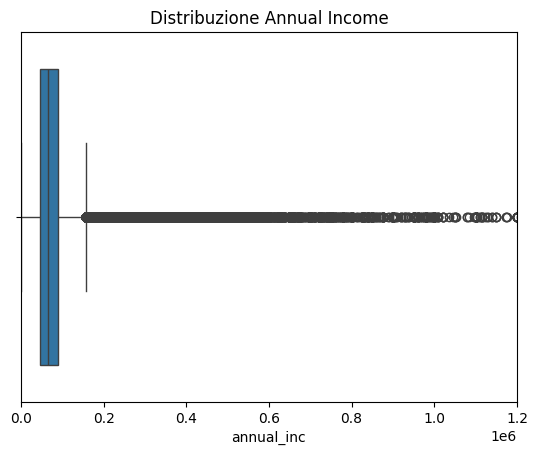

Whisker Lo = 0.00
Whisker Hi = 156307.00
Number of rows with annual_inc = 0: 361


In [19]:
# 1) Draw the boxplot
fig, ax = plt.subplots()
sns.boxplot(x=df_imputed['annual_inc'], ax=ax)
ax.set_title("Distribuzione Annual Income")
plt.xlim(0, 1200000)
plt.show()

# 2) Calculate the statistics directly from the plot
stats_list_2 = boxplot_stats(df_imputed['annual_inc'], whis=1.5)
stats_2 = stats_list_2[0]

# 3) Extract the values
wh_lo_annual_inc= stats_2['whislo']
wh_hi_annual_inc= stats_2['whishi']

# 4) Print everything
print(f"Whisker Lo = {wh_lo_annual_inc:.2f}")
print(f"Whisker Hi = {wh_hi_annual_inc:.2f}")

# 5) Count the annual_inc = 0 rows
count_zero_income = (df_imputed['annual_inc'] == 0).sum()
print(f"Number of rows with annual_inc = 0: {count_zero_income}")   

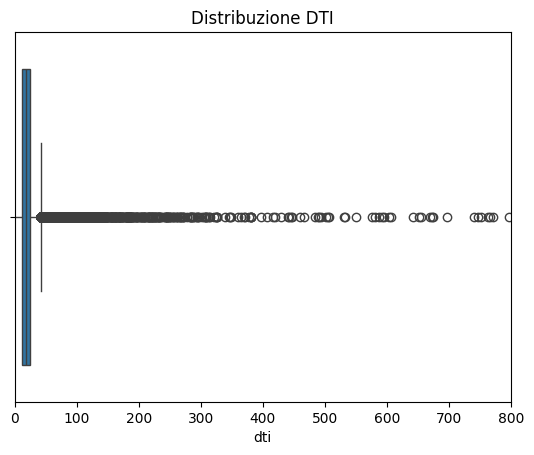

Whisker Lo = -1.00
Whisker Hi = 42.42


In [21]:
# 1) Draw the boxplot
fig, ax = plt.subplots()
sns.boxplot(x=df_imputed['dti'], ax=ax)
ax.set_title("Distribuzione DTI")
plt.xlim(0, 800)
plt.show()

# 2) Calculate the statistics directly from the plot
stats_list_3 = boxplot_stats(df_imputed['dti'], whis=1.5)
stats_3 = stats_list_3[0]

# 3) Extract the values
wh_lo_dti= stats_3['whislo']
wh_hi_dti= stats_3['whishi']

# 4) Print everything
print(f"Whisker Lo = {wh_lo_dti:.2f}")
print(f"Whisker Hi = {wh_hi_dti:.2f}")

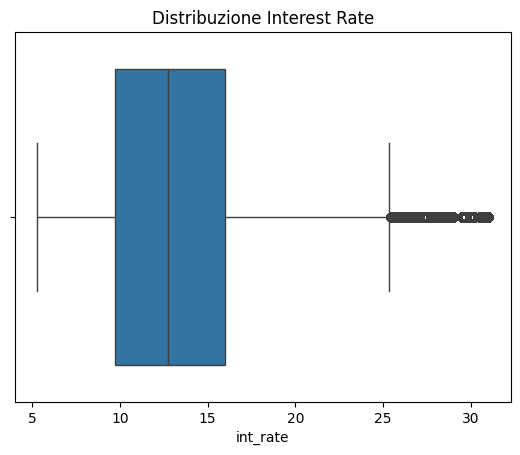

Whisker Lo = 5.31
Whisker Hi = 25.34


In [22]:
# 1) Draw the boxplot
fig, ax = plt.subplots()
sns.boxplot(x=df_imputed['int_rate'], ax=ax)
ax.set_title("Distribuzione Interest Rate")
plt.show()

# 2) Calculate the statistics directly from the plot
stats_list_1 = boxplot_stats(df_imputed['int_rate'], whis=1.5)
stats_1 = stats_list_1[0]

# 3) Extract the values
wh_lo_int_rate= stats_1['whislo']
wh_hi_int_rate= stats_1['whishi']

# 4) Print everything
print(f"Whisker Lo = {wh_lo_int_rate:.2f}")
print(f"Whisker Hi = {wh_hi_int_rate:.2f}")


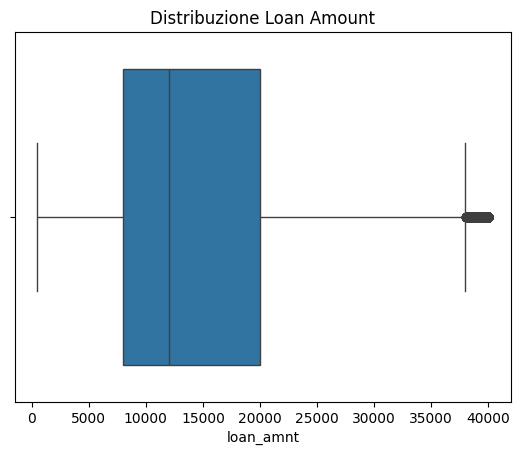

Whisker Lo = 500.00
Whisker Hi = 38000.00


In [23]:
# 1) Draw the boxplot
fig, ax = plt.subplots()
sns.boxplot(x=df_imputed['loan_amnt'], ax=ax)
ax.set_title("Distribuzione Loan Amount")
plt.show()

# 2) Calculate the statistics directly from the plot
stats_list_4 = boxplot_stats(df_imputed['loan_amnt'], whis=1.5)
stats_4 = stats_list_4[0]

# 3) Extract the values
wh_lo_loan_amnt= stats_4['whislo']
wh_hi_loan_amnt= stats_4['whishi']


# 4) Print everything
print(f"Whisker Lo = {wh_lo_loan_amnt:.2f}")
print(f"Whisker Hi = {wh_hi_loan_amnt:.2f}")

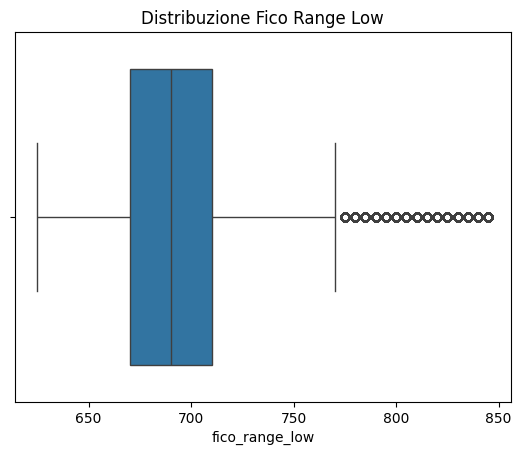

Whisker Lo = 625.00
Whisker Hi = 770.00


In [24]:
# 1) Draw the boxplot
fig, ax = plt.subplots()
sns.boxplot(x=df_imputed['fico_range_low'], ax=ax)
ax.set_title("Distribuzione Fico Range Low")
plt.show()

# 2) Calculate the statistics directly from the plot
stats_list_6 = boxplot_stats(df_imputed['fico_range_low'], whis=1.5)
stats_6 = stats_list_6[0]

# 3) Extract the values
wh_lo_fico_range_low= stats_6['whislo']
wh_hi_fico_range_low= stats_6['whishi']


# 4) Print everything
print(f"Whisker Lo = {wh_lo_fico_range_low:.2f}")
print(f"Whisker Hi = {wh_hi_fico_range_low:.2f}")

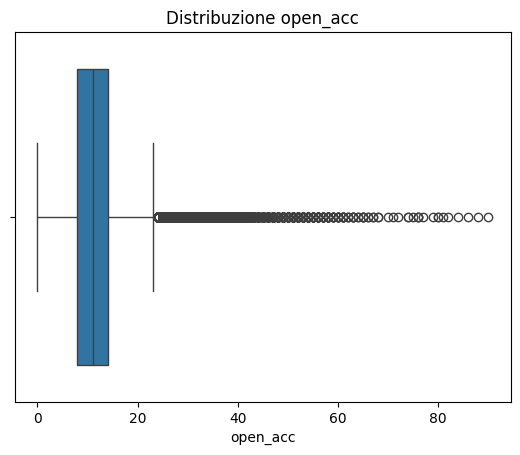

Whisker Lo = 0.00
Whisker Hi = 23.00


In [25]:
# 1) Draw the boxplot
fig, ax = plt.subplots()
sns.boxplot(x=df_imputed['open_acc'], ax=ax)
ax.set_title("Distribuzione open_acc")
plt.show()

# 2) Calculate the statistics directly from the plot
stats_list_7 = boxplot_stats(df_imputed['open_acc'], whis=1.5)
stats_7 = stats_list_7[0]

# 3) Extract the values
wh_lo_open_acc= stats_7['whislo']
wh_hi_open_acc= stats_7['whishi']


# 4) Print everything
print(f"Whisker Lo = {wh_lo_open_acc:.2f}")
print(f"Whisker Hi = {wh_hi_open_acc:.2f}")

In [26]:
# 1) Define the columns on which you want to remove outliers
cols = ['loan_amnt',
    'dti', 'int_rate', 'fico_range_low', 'fico_range_high', 'open_acc'
]

# 2) Calculate, for each column, the two whisker extremes (whislo, whishi)
bounds = {}
for col in cols:
    stats = boxplot_stats(df_imputed[col], whis=1.5)[0]
    bounds[col] = (stats['whislo'], stats['whishi'])
    print(f"{col:15s} → [{stats['whislo']:.2f}, {stats['whishi']:.2f}]")

# 3) Build a cumulative mask that keeps only the values within the whiskers
mask = np.ones(len(df_imputed), dtype=bool)
for col, (lo, hi) in bounds.items():
    mask &= df_imputed[col].between(lo, hi)

# 4) Drop the annual_inc = 0 rows
df_final = df[df['annual_inc'] != 0]  

# 5) Apply the filter in a single pass
df_final = df_imputed.loc[mask].copy()

# 6) Check how many you discarded
print("Original shape:", df_imputed.shape)
print("No‐outlier shape:", df_final.shape)
print("Rows dropped:", len(df_imputed) - len(df_final))
percentage_dropped = -(len(df_final) - len(df_imputed)) / len(df_imputed) * 100
print("Percentage of rows dropped: {:.2f}%".format(percentage_dropped))



loan_amnt       → [500.00, 38000.00]
dti             → [-1.00, 42.42]
int_rate        → [5.31, 25.34]
fico_range_low  → [625.00, 770.00]
fico_range_high → [629.00, 774.00]
open_acc        → [0.00, 23.00]
Original shape: (1344832, 26)
No‐outlier shape: (1220198, 26)
Rows dropped: 124634
Percentage of rows dropped: 9.27%


In [27]:
# 4) Drop the dti = 0 rows
df_final_2 = df_final[df_final['dti'] != 0]  

### Create new variables

In [28]:
df_final_2['debt_burden'] = df_final_2['annual_inc'] / df_final_2['dti'] #avoid division by zero
df_final_2['fico_average'] = (df_final_2['fico_range_high'] + df_final_2['fico_range_low'])/ 2
df_final_2['credit_inquiry_density'] = df_final_2['inq_last_6mths'] / (df_final_2['open_acc']+1)

df_final_2['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')             
df_final_2['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df_final_2['credit_age_days'] = (df_final_2['issue_d'] - df_final_2['earliest_cr_line']).dt.days
df_final_2['credit_age_years'] = df_final_2['credit_age_days'] / 365
print("\nColumns in DataFrame:", df_final_2.columns.tolist())


Columns in DataFrame: ['dti', 'inq_last_6mths', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'tax_liens', 'emp_length', 'mort_acc', 'mths_since_last_delinq', 'annual_inc', 'debt_settlement_flag', 'delinq_2yrs', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'int_rate', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'revol_bal', 'term', 'verification_status', 'debt_burden', 'fico_average', 'credit_inquiry_density', 'issue_d', 'earliest_cr_line', 'credit_age_days', 'credit_age_years']


In [29]:
df_final_2.dtypes

dti                                  float64
inq_last_6mths                       float64
tot_cur_bal                          float64
revol_util                           float64
collections_12_mths_ex_med           float64
pub_rec_bankruptcies                 float64
tax_liens                            float64
emp_length                           float64
mort_acc                             float64
mths_since_last_delinq               float64
annual_inc                           float64
debt_settlement_flag                   int64
delinq_2yrs                          float64
fico_range_high                      float64
fico_range_low                       float64
grade                                  int64
home_ownership                        object
int_rate                             float64
loan_amnt                            float64
loan_status                            int64
open_acc                             float64
pub_rec                              float64
purpose   

### Correlation

In [30]:
corr = df_final_2.corr(numeric_only= True)
corr

,dti,inq_last_6mths,tot_cur_bal,revol_util,collections_12_mths_ex_med,pub_rec_bankruptcies,tax_liens,emp_length,mort_acc,mths_since_last_delinq,...,open_acc,pub_rec,revol_bal,term,verification_status,debt_burden,fico_average,credit_inquiry_density,credit_age_days,credit_age_years
dti,1.000000,-0.011711,0.009375,0.168354,-0.003240,-0.032454,-0.031712,0.017033,-0.019775,0.037619,...,0.300675,-0.048627,0.135685,-0.063498,-0.010301,-0.016695,-0.032633,-0.090668,0.051964,0.051964
inq_last_6mths,-0.011711,1.000000,0.022161,-0.090362,0.010374,0.073443,0.007768,0.000861,0.040562,-0.026688,...,0.117339,0.058599,-0.018529,-0.012083,0.017219,-0.000033,-0.080241,0.885568,0.000908,0.000908
tot_cur_bal,0.009375,0.022161,1.000000,0.102974,-0.008275,-0.091109,0.001760,0.123329,0.529356,-0.082694,...,0.239154,-0.061314,0.430957,-0.105803,0.004284,0.002657,0.121941,-0.040866,0.179822,0.179822
revol_util,0.168354,-0.090362,0.102974,1.000000,-0.044169,-0.114482,-0.019265,0.053605,0.043082,0.058295,...,-0.137631,-0.095083,0.245462,-0.064233,0.053164,-0.004076,-0.369132,-0.053482,0.035929,0.035929
collections_12_mths_ex_med,-0.003240,0.010374,-0.008275,-0.044169,1.000000,-0.001149,0.012837,-0.005636,-0.007412,-0.053462,...,0.012476,0.013890,-0.023864,0.009332,0.019475,-0.000128,-0.070744,0.005355,0.009080,0.009080
pub_rec_bankruptcies,-0.032454,0.073443,-0.091109,-0.114482,-0.001149,1.000000,0.034448,0.003770,0.020809,0.072416,...,-0.019977,0.646997,-0.123427,0.015384,0.030207,0.000523,-0.205026,0.066208,0.076171,0.076171
tax_liens,-0.031712,0.007768,0.001760,-0.019265,0.012837,0.034448,1.000000,0.008006,-0.006040,-0.030110,...,-0.005354,0.700763,-0.013198,0.013450,0.032199,0.000491,-0.053996,0.006115,0.038835,0.038835
emp_length,0.017033,0.000861,0.123329,0.053605,-0.005636,0.003770,0.008006,1.000000,0.166289,-0.053605,...,0.070266,0.012254,0.090748,-0.073276,-0.006965,0.001973,0.012069,-0.022635,0.124310,0.124310
mort_acc,-0.019775,0.040562,0.529356,0.043082,-0.007412,0.020809,-0.006040,0.166289,1.000000,-0.147406,...,0.143907,0.008413,0.205185,-0.104365,-0.001763,0.000837,0.058804,-0.003513,0.289116,0.289116
mths_since_last_delinq,0.037619,-0.026688,-0.082694,0.058295,-0.053462,0.072416,-0.030110,-0.053605,-0.147406,1.000000,...,-0.067269,0.007928,0.068480,-0.012770,-0.032613,-0.002398,0.282595,-0.002632,-0.164236,-0.164236


<Axes: >

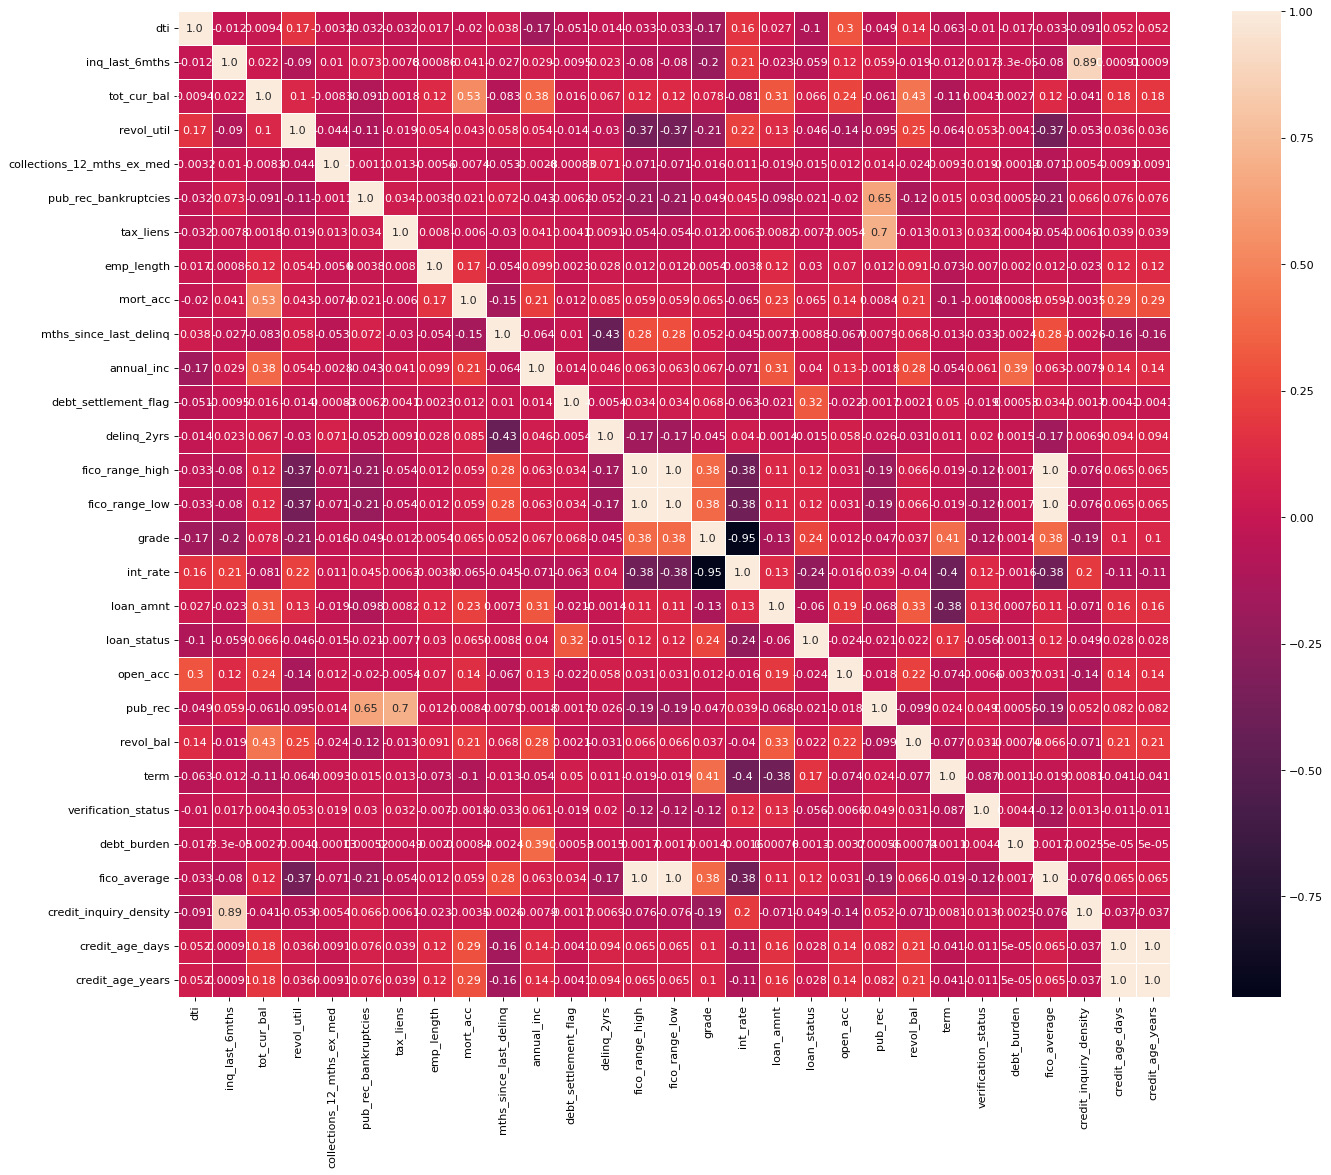

In [31]:
plt.figure(figsize=(20,16), dpi= 80)
sns.heatmap(corr, annot=True , fmt=".2" ,linewidths=.9)

In [32]:
# We drop the column that has an equal correlation and the datetime columns 
df_final_2 = df_final_2.drop(columns=['fico_range_high','fico_range_low','credit_age_days','issue_d','earliest_cr_line'])

### Countplot of Loan Status

loan_status
1    979060
0    240554
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='loan_status'>

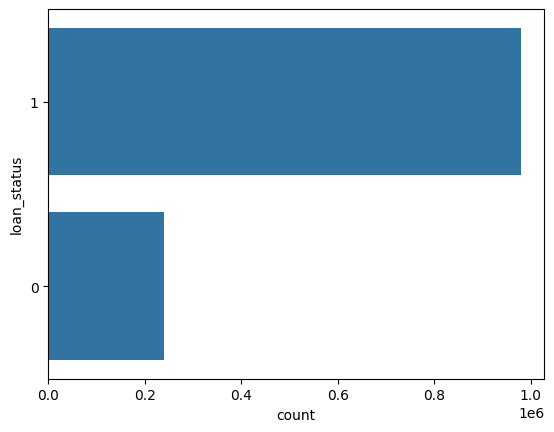

In [33]:
df_countplot = df_final_2.copy()
print(df_countplot["loan_status"].value_counts())
df_countplot['loan_status'] = df_countplot['loan_status'].astype(str).str.strip()
sns.countplot(df_countplot["loan_status"])

### Train Test Split

In [34]:
df_final_sample = df_final_2.sample(n=50000, random_state=123)

In [35]:
# Create a new continuous variable, related to loan status, in order to apply regression model
df_final_tts = df_final_sample.copy()

num_bins = 10
# Create labels 0 through 9, or custom labels
labels = [f'bin_{i}' for i in range(num_bins)]

# Compute bin edges and bin each fico_avg
df_final_tts['fico_bucket'] = pd.cut(
    df_final_tts['fico_average'],
    bins=num_bins,
    labels=labels,
    include_lowest=True
)
pd_rates = (
    df_final_tts
    .groupby('fico_bucket')['loan_status']
    .mean()
    .reset_index(name='pd_empirical')
)

df_final_tts = df_final_tts.merge(pd_rates, on='fico_bucket', how='left')

In [36]:
print("\nColumns in DataFrame:", df_final_tts.columns.tolist())


Columns in DataFrame: ['dti', 'inq_last_6mths', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'tax_liens', 'emp_length', 'mort_acc', 'mths_since_last_delinq', 'annual_inc', 'debt_settlement_flag', 'delinq_2yrs', 'grade', 'home_ownership', 'int_rate', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'revol_bal', 'term', 'verification_status', 'debt_burden', 'fico_average', 'credit_inquiry_density', 'credit_age_years', 'fico_bucket', 'pd_empirical']


In [37]:
correlazione = df_final_tts['loan_status'].corr(df_final_tts['pd_empirical'])

print(f"Correlazione tra loan_status e pd_empirical: {correlazione:.4f}")

Correlazione tra loan_status e pd_empirical: 0.1175


In [38]:
# Define X and y 
X = df_final_tts.drop(['loan_status','pd_empirical','fico_bucket'] , axis = 1)
y_clf = df_final_tts['loan_status']
y_reg = df_final_tts['pd_empirical']

In [39]:
# Understand the shape
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.20, stratify=y_clf)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.20)

In [40]:
# Understand if the value are unbalanced
y_train_clf.value_counts()


loan_status
1    32118
0     7882
Name: count, dtype: int64

In [41]:
y_train_reg.value_counts()

pd_empirical
0.749652    10988
0.777168     6399
0.843120     5435
0.796688     5341
0.808088     4677
0.862335     2495
0.869224     1724
0.886022     1121
0.898305      947
0.910222      873
Name: count, dtype: int64

In [42]:
# Balancing target by over sampling, train the model in a good way
oversampler = RandomOverSampler()
X_train_o_clf, y_train_o_clf = oversampler.fit_resample(X_train_clf, y_train_clf)
y_train_o_clf.value_counts()

loan_status
1    32118
0    32118
Name: count, dtype: int64

In [43]:
# 1) Select all numeric columns, then explicitly exclude the unwanted ones
df_final_clf = X_train_clf.copy()
all_numeric = df_final_clf.select_dtypes(include='number').columns.tolist()
to_exclude = ['loan_status']
numeric_cols = [col for col in all_numeric if col not in to_exclude]

# 2) Select all categorical columns
categorical_cols = df_final_clf.select_dtypes(include=['object', 'category']).columns.tolist()

# 3) Build the sub-pipelines
numeric_pipeline = Pipeline([
    ('scaler', preprocessing.MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4) Assemble the ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,    numeric_cols),
    ('cat', categorical_pipeline, categorical_cols),
])

# 5) Full pipeline
full_pipeline = Pipeline([
    ('prep', preprocessor)
])

# 6) Fit & transform
X_train_prepared = full_pipeline.fit_transform(X_train_o_clf)
X_test_prepared  = full_pipeline.transform(X_test_clf)

# 7) Reconstruct DataFrames with proper column names
#    a) one-hot feature names
ohe_names = full_pipeline.named_steps['prep'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_cols).tolist()

#    b) numeric feature names
num_names = numeric_cols

all_feature_names = num_names + ohe_names

X_train_final_clf = pd.DataFrame(
    X_train_prepared,
    columns=all_feature_names,
    index=X_train_o_clf.index
)
X_test_final_clf = pd.DataFrame(
    X_test_prepared,
    columns=all_feature_names,
    index=X_test_clf.index
)

# 8) Verify
print("Shape X_train_final:", X_train_final_clf.shape)
print("Shape X_test_final: ",  X_test_final_clf.shape)
print("Sample columns:", all_feature_names[:10], "…")

Shape X_train_final: (64236, 33)
Shape X_test_final:  (10000, 33)
Sample columns: ['dti', 'inq_last_6mths', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'tax_liens', 'emp_length', 'mort_acc', 'mths_since_last_delinq'] …


In [44]:
#  (Same as we do for X_train_clf before)
df_train = X_train_reg.copy()

# 1) Numeric columns: grab all numbers except 'pd_empirical'
numeric_cols = [
    col for col in df_train.select_dtypes(include='number').columns 
    if col != 'pd_empirical'
]

# 2) Categorical columns: everything object/category
categorical_cols = df_train.select_dtypes(include=['object','category']).columns.tolist()

# 3) Build pipelines
numeric_pipeline = Pipeline([
    ('scaler', preprocessing.MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4) ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,    numeric_cols),
    ('cat', categorical_pipeline, categorical_cols),
])

# 5) Full pipeline
full_pipeline = Pipeline([
    ('prep', preprocessor)
])

# 6) Fit & transform on the right data
X_train_prepared = full_pipeline.fit_transform(X_train_reg)
X_test_prepared  = full_pipeline.transform(X_test_reg)

# 7) Reconstruct DataFrames with proper feature names
#  a) get one-hot names directly from the fitted OneHotEncoder
ohe = full_pipeline.named_steps['prep'] \
                   .named_transformers_['cat'] \
                   .named_steps['onehot']
ohe_names = ohe.get_feature_names_out(categorical_cols).tolist()

#  b) numeric names are just numeric_cols
all_feature_names = numeric_cols + ohe_names

X_train_final_reg = pd.DataFrame(
    X_train_prepared,
    columns=all_feature_names,
    index=X_train_reg.index
)
X_test_final_reg = pd.DataFrame(
    X_test_prepared,
    columns=all_feature_names,
    index=X_test_reg.index
)

# 8) Verify
print("Shape X_train_final:", X_train_final_reg.shape)
print("Shape X_test_final: ",  X_test_final_reg.shape)
print("Sample columns:", all_feature_names[:10], "…")

Shape X_train_final: (40000, 33)
Shape X_test_final:  (10000, 33)
Sample columns: ['dti', 'inq_last_6mths', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'tax_liens', 'emp_length', 'mort_acc', 'mths_since_last_delinq'] …


In [45]:
# Understand the types of every variables
X_train_final_clf.dtypes

dti                           float64
inq_last_6mths                float64
tot_cur_bal                   float64
revol_util                    float64
collections_12_mths_ex_med    float64
pub_rec_bankruptcies          float64
tax_liens                     float64
emp_length                    float64
mort_acc                      float64
mths_since_last_delinq        float64
annual_inc                    float64
debt_settlement_flag          float64
delinq_2yrs                   float64
grade                         float64
int_rate                      float64
loan_amnt                     float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
term                          float64
verification_status           float64
debt_burden                   float64
fico_average                  float64
credit_inquiry_density        float64
credit_age_years              float64
home_ownership_MORTGAGE       float64
home_ownersh

## Clustering

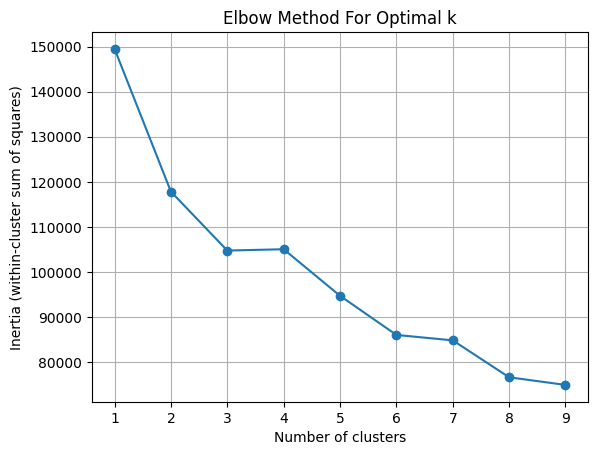

In [44]:
X_total = pd.concat([X_train_final_clf, X_test_final_clf], axis=0, ignore_index=True)

inertia = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_total)
    inertia.append(km.inertia_)

# Plot
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.grid(True)
plt.show()

In [90]:
# Define the number of clusters
nclusters = 3

km = KMeans(n_clusters=nclusters, random_state=42)
km.fit(X_total)

X_total['cluster'] = km.labels_
X_total.head()

,dti,inq_last_6mths,tot_cur_bal,revol_util,collections_12_mths_ex_med,pub_rec_bankruptcies,tax_liens,emp_length,mort_acc,mths_since_last_delinq,...,credit_age_years,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_auto,purpose_business,purpose_consolidation,purpose_home,purpose_personal,cluster
0,0.643700,0.000000,0.013866,0.038386,0.0,0.0,0.0,0.818182,0.083333,0.237885,...,0.153134,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
1,0.632138,0.000000,0.005819,0.099545,0.0,0.0,0.0,0.818182,0.000000,1.000000,...,0.158609,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,0.601463,0.142857,0.006415,0.266753,0.0,0.0,0.0,1.000000,0.000000,0.246696,...,0.435007,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,0.204814,0.000000,0.046256,0.178920,0.0,0.0,0.0,1.000000,0.250000,0.013216,...,0.489272,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.411279,0.142857,0.015041,0.342225,0.0,0.0,0.0,0.181818,0.000000,1.000000,...,0.054265,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [91]:
# Group by cluster and look at average feature values
cluster_summary = X_total.groupby('cluster').mean()
cluster_summary

,dti,inq_last_6mths,tot_cur_bal,revol_util,collections_12_mths_ex_med,pub_rec_bankruptcies,tax_liens,emp_length,mort_acc,mths_since_last_delinq,...,credit_inquiry_density,credit_age_years,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_auto,purpose_business,purpose_consolidation,purpose_home,purpose_personal
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.439603,0.100895,0.049763,0.361337,0.003733,0.024013,0.002987,0.649168,0.102831,0.528706,...,0.048041,0.229573,1.0,0.0,0.0,0.025145,0.009188,0.803243,0.100207,0.062216
1,0.433861,0.093724,0.012500,0.349253,0.004374,0.025528,0.003373,0.528719,0.021902,0.598326,...,0.050656,0.182368,0.0,0.0,1.0,0.031900,0.015380,0.831292,0.030602,0.090826
2,0.445347,0.102773,0.025155,0.324813,0.003662,0.022078,0.003239,0.575784,0.050333,0.550733,...,0.053007,0.223228,0.0,1.0,0.0,0.038389,0.012249,0.750852,0.111125,0.087385


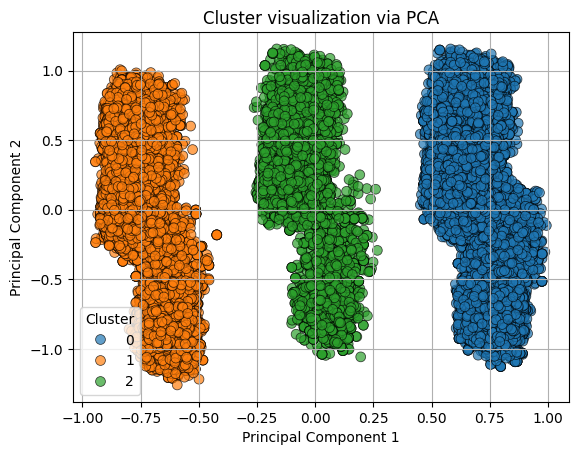

In [92]:
# 1) Extract features (excluding 'cluster')
features = X_total.drop(columns='cluster')

# 2) Reduce to 2D via PCA
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(features)

# 3) Construct DataFrame for plotting
viz_df = X_total.copy()
viz_df['PC1'] = components[:, 0]
viz_df['PC2'] = components[:, 1]

# 4) Scatter plot
sns.scatterplot( data=viz_df,x='PC1', y='PC2',hue='cluster',palette='tab10',alpha=0.7,s=50,edgecolor='k')
plt.title('Cluster visualization via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## Models

### Decision Tree Classifier

In [103]:
# 1) Create Decision Tree classifer object
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# 2) Train Decision Tree Classifer
clf = clf.fit(X_train_final_clf,y_train_o_clf)

# 3) Predict the response for test dataset
y_pred = clf.predict(X_test_final_clf)
y_pred_proba = clf.predict_proba(X_test_final_clf)

In [104]:
y_pred_proba = y_pred_proba[:,1]

In [105]:
print("Accuracy:", accuracy_score(y_test_clf, y_pred))
print("ROC Score:", roc_auc_score(y_test_clf, y_pred_proba))
print("RGA Value:", core.rga(y_test_clf, y_pred_proba))
print("Precision Score:", precision_score(y_test_clf, y_pred))
print("Recall Score:", recall_score(y_test_clf, y_pred))
print("F1 Score:", f1_score(y_test_clf, y_pred))

Accuracy: 0.7452
ROC Score: 0.5923421686442338
RGA Value: 0.5923421686442338
Precision Score: 0.8391487255629795
Recall Score: 0.8445828144458282
F1 Score: 0.8418570009930486


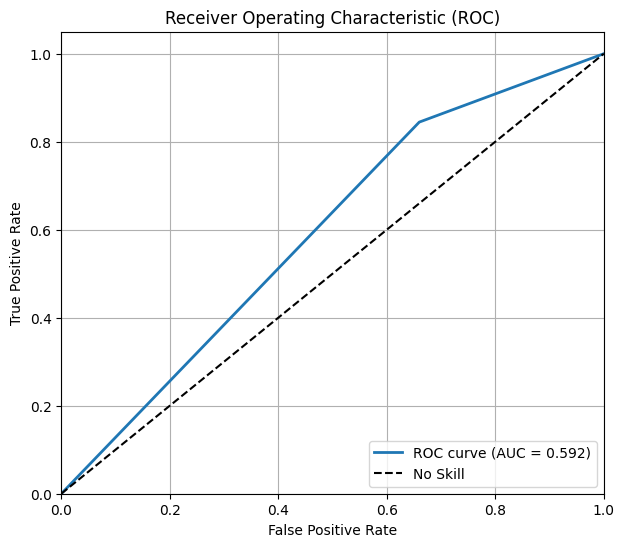

In [106]:
# Define our variables to plot
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
auc_score_clf = roc_auc_score(y_test_clf, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score_clf:.3f})', linewidth=2)  
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')                          
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')                                           
plt.ylabel('True Positive Rate')                                             
plt.title('Receiver Operating Characteristic (ROC)')                        
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

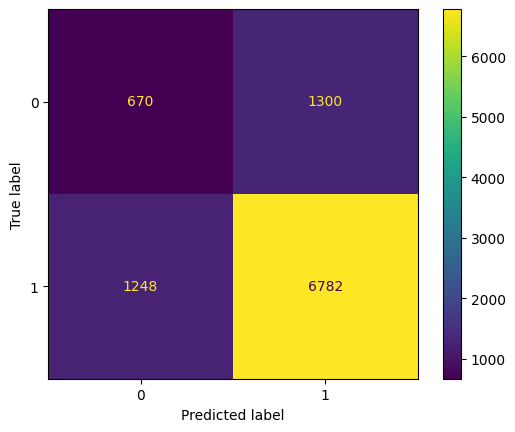

In [54]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_clf, y_pred))
disp.plot()

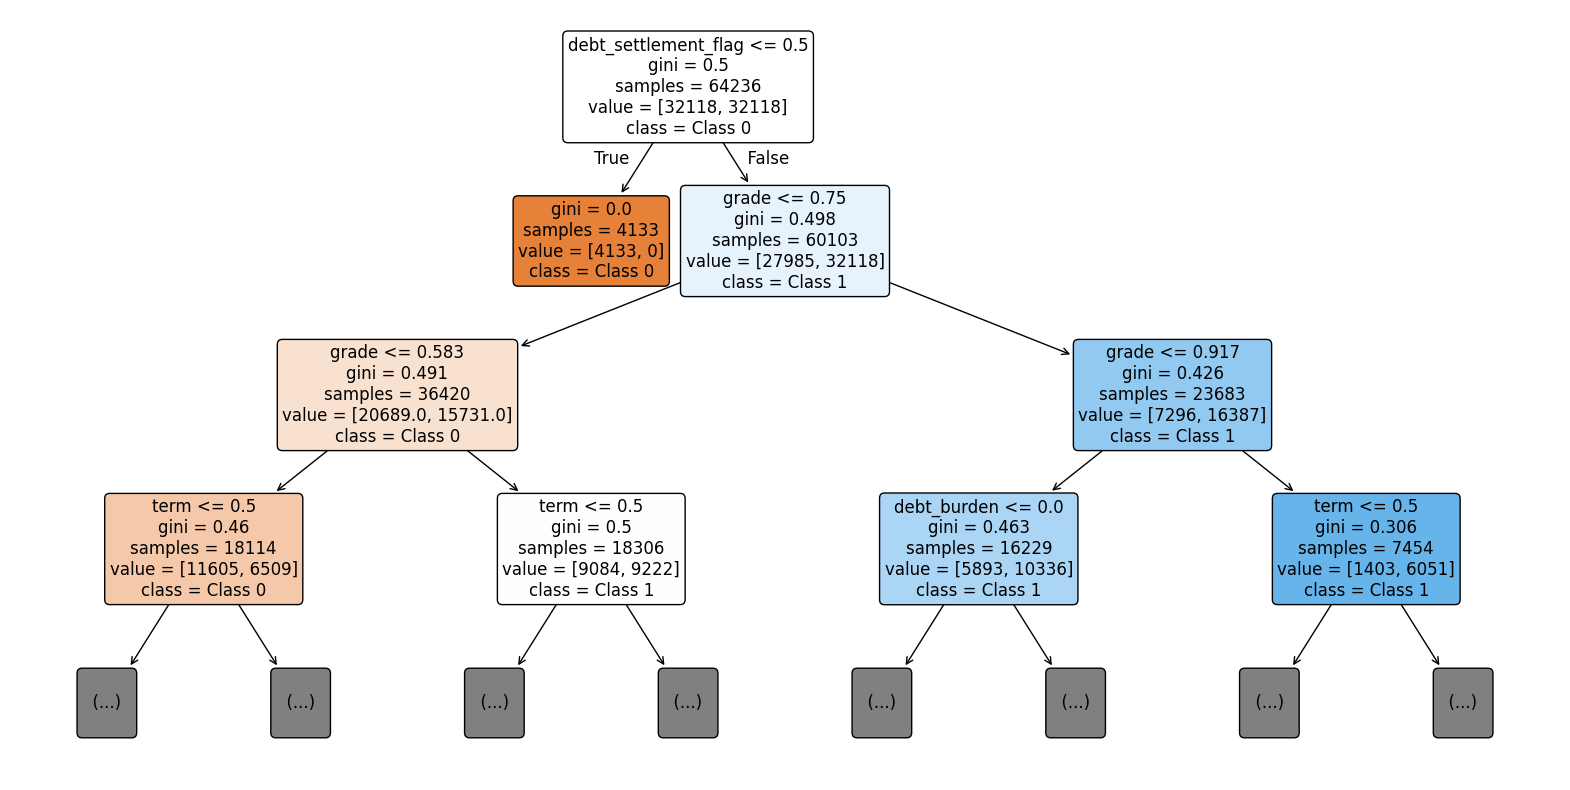

In [55]:
plt.figure(figsize=(20,10))  # Adjust the figure size
plot_tree(clf, 
               feature_names=X_train_final_clf.columns,  # optional, if you have feature names
               class_names=['Class 0', 'Class 1'],  # replace with your class labels
               filled=True, 
               rounded=True, 
               fontsize=12,
              max_depth= 3)
plt.show()

### Random Forest Classifier

In [56]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_final_clf, y_train_o_clf)
rf_clf_predited = rf_clf.predict(X_test_final_clf)
rf_clf_predicted_proba = rf_clf.predict_proba(X_test_final_clf)[:,1]

In [57]:
print("Accuracy:", accuracy_score(y_test_clf, rf_clf_predited))
print("ROC Score:", roc_auc_score(y_test_clf, rf_clf_predicted_proba))
print("RGA Value:", core.rga(y_test_clf, rf_clf_predicted_proba))
print("Precision Score:", precision_score(y_test_clf, rf_clf_predited))
print("Recall Score:", recall_score(y_test_clf, rf_clf_predited))
print("F1 Score:", f1_score(y_test_clf, rf_clf_predited))

Accuracy: 0.8234
ROC Score: 0.726508398075744
RGA Value: 0.7265083980757439
Precision Score: 0.8350449293966624
Recall Score: 0.9721046077210461
F1 Score: 0.8983772586028311


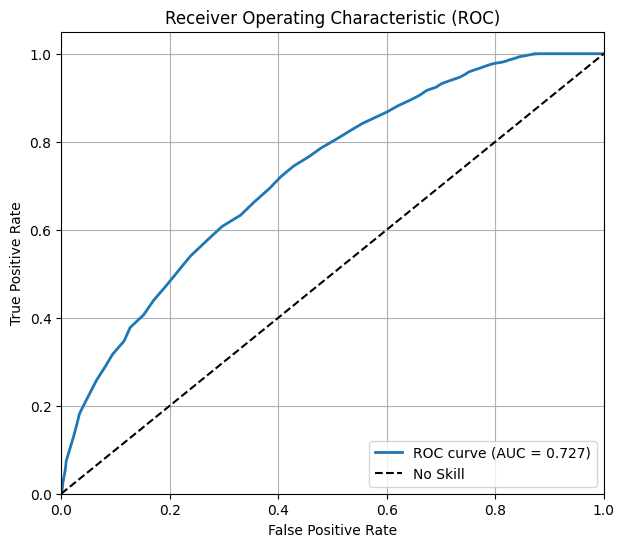

In [58]:
# Define our variables to plot
auc_score_rf_clf = roc_auc_score(y_test_clf, rf_clf_predicted_proba)
fpr_rf_clf, tpr_rf_clf, thresholds_rf_clf = roc_curve(y_test_clf, rf_clf_predicted_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf_clf, tpr_rf_clf, label=f'ROC curve (AUC = {auc_score_rf_clf:.3f})', linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')                         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')                                       
plt.ylabel('True Positive Rate')                                        
plt.title('Receiver Operating Characteristic (ROC)')                    
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

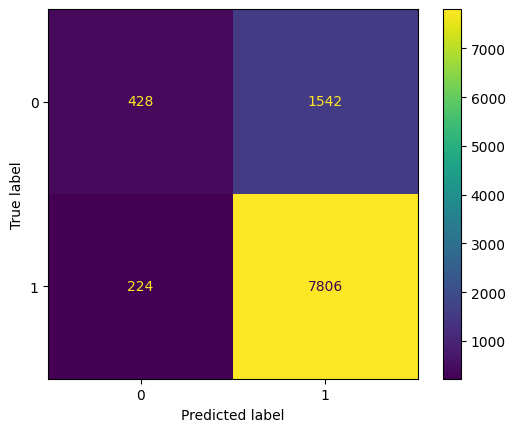

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_clf, rf_clf_predited))
disp.plot()

### Logistic Regression

In [60]:
log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train_final_clf, y_train_o_clf)
log_clf_predited = log_clf.predict(X_test_final_clf)
log_clf_predicted_proba = log_clf.predict_proba(X_test_final_clf)[:,1]

In [61]:
print("Accuracy:", accuracy_score(y_test_clf, log_clf_predited))
print("ROC Score:", roc_auc_score(y_test_clf, log_clf_predicted_proba))
print("RGA Value:", core.rga(y_test_clf, log_clf_predicted_proba))
print("Precision Score:", precision_score(y_test_clf, log_clf_predited))
print("Recall Score:", recall_score(y_test_clf, log_clf_predited))
print("F1 Score:", f1_score(y_test_clf, log_clf_predited))


Accuracy: 0.703
ROC Score: 0.737465595387854
RGA Value: 0.737465595387854
Precision Score: 0.8828692493946732
Recall Score: 0.7265255292652553
F1 Score: 0.79710342943025


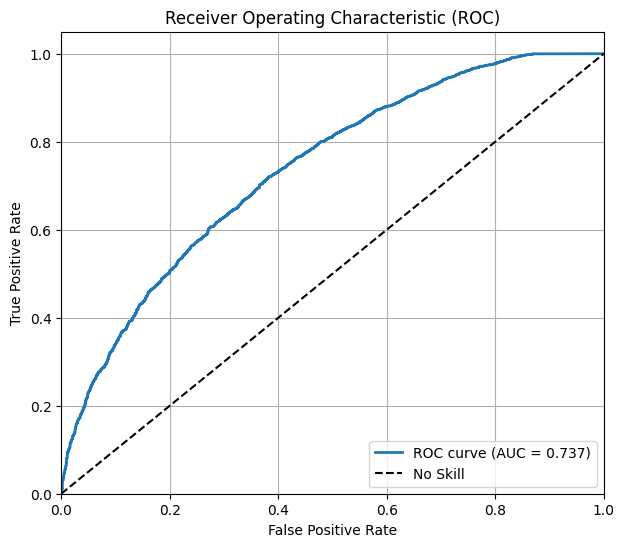

In [62]:
# Define our variables to plot
auc_score_log_clf = roc_auc_score(y_test_clf, log_clf_predicted_proba)
fpr_log_clf, tpr_log_clf, thresholds_log_clf = roc_curve(y_test_clf, log_clf_predicted_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr_log_clf, tpr_log_clf, label=f'ROC curve (AUC = {auc_score_log_clf:.3f})', linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')                         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')                                       
plt.ylabel('True Positive Rate')                                        
plt.title('Receiver Operating Characteristic (ROC)')                    
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

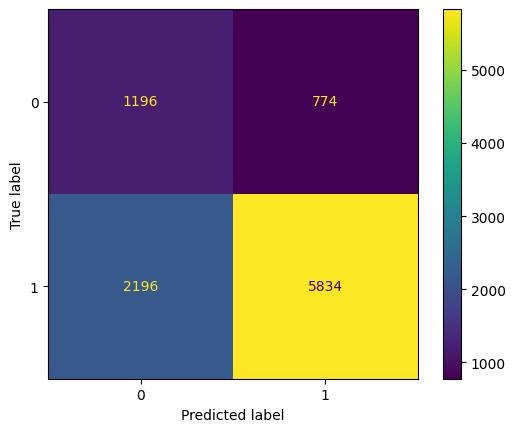

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_clf, log_clf_predited))
disp.plot()

### MLP Classifier

In [64]:
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_final_clf, y_train_o_clf)
mlp_predicted = mlp.predict(X_test_final_clf)
mlp_predicted_proba = mlp.predict_proba(X_test_final_clf)[:,1]

In [65]:
print("Accuracy:", accuracy_score(y_test_clf, mlp_predicted))
print("ROC Score:", roc_auc_score(y_test_clf, mlp_predicted_proba))
print("RGA Value:", core.rga(y_test_clf, mlp_predicted_proba))
print("Precision Score:", precision_score(y_test_clf, mlp_predicted))
print("Recall Score:", recall_score(y_test_clf, mlp_predicted))
print("F1 Score:", f1_score(y_test_clf, mlp_predicted))

Accuracy: 0.6335
ROC Score: 0.7018288018913844
RGA Value: 0.7018288018913844
Precision Score: 0.8808235909963357
Recall Score: 0.6286425902864259
F1 Score: 0.7336676113654531


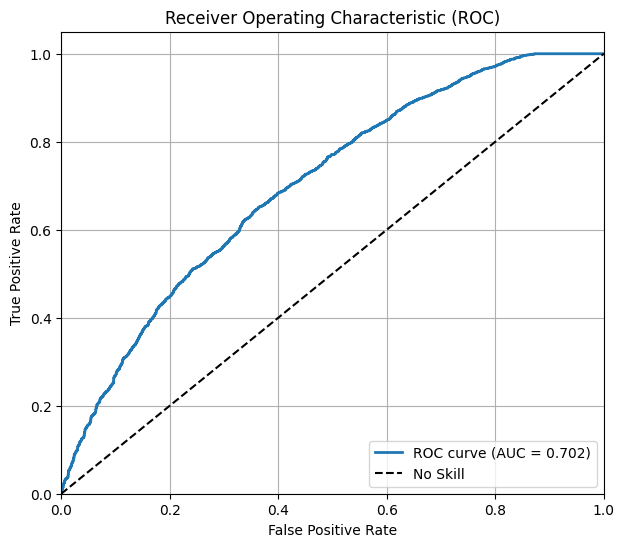

In [66]:
# Define our variables to plot
auc_score_mlp = roc_auc_score(y_test_clf, mlp_predicted_proba)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_clf, mlp_predicted_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr_mlp, tpr_mlp, label=f'ROC curve (AUC = {auc_score_mlp:.3f})', linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')                         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')                                       
plt.ylabel('True Positive Rate')                                        
plt.title('Receiver Operating Characteristic (ROC)')                    
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

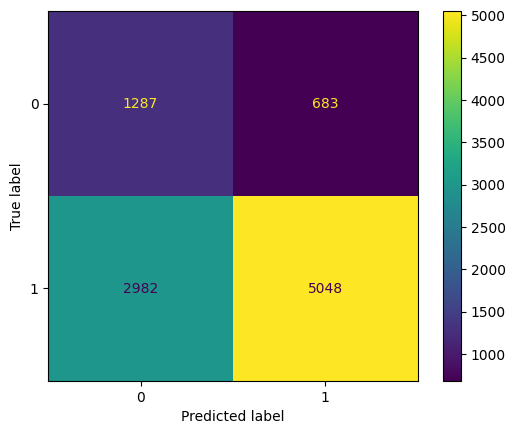

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_clf, mlp_predicted))
disp.plot()

### Honorable Mentions

#### RF Regressor

In [68]:
rf_reg = RandomForestRegressor(random_state=123)
rf_reg.fit(X_train_final_reg, y_train_reg)
rf_reg_predicted = rf_reg.predict(X_test_final_reg)

In [69]:
print("R2 score:", r2_score(y_test_reg, rf_reg_predicted))
print("RGA Value:", core.rga(y_test_reg, rf_reg_predicted))

R2 score: 1.0
RGA Value: 1.0


#### Linear Regression

In [70]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_final_reg, y_train_reg)
lin_reg_predicted = lin_reg.predict(X_test_final_reg)


In [71]:
print("Accuracy:", r2_score(y_test_reg, lin_reg_predicted))
print("RGA Value:", core.rga(y_test_reg, lin_reg_predicted))

Accuracy: 0.9634161901157701
RGA Value: 0.9997320390671668


### Comparison and results

In [72]:
print('******************** Accuracy *********************')
print("Accuracy of Decision Tree Classifier is:", accuracy_score(y_test_clf, y_pred)*100)
print("Accuracy of Random Forest Classifier is:", accuracy_score(y_test_clf, rf_clf_predited)*100)
print("Accuracy of Logistic Regression is:", accuracy_score(y_test_clf, log_clf_predited)*100)
print("Accuracy of MLP Classifier is:", accuracy_score(y_test_clf, mlp_predicted)*100)

******************** Accuracy *********************
Accuracy of Decision Tree Classifier is: 74.52
Accuracy of Random Forest Classifier is: 82.34
Accuracy of Logistic Regression is: 70.3
Accuracy of MLP Classifier is: 63.349999999999994


In [73]:
print('******************** ROC Score *********************')
print("ROC Score of Decision Tree Classifier is:", roc_auc_score(y_test_clf, y_pred_proba)*100)
print("ROC Score of Random Forest Classifier is:", roc_auc_score(y_test_clf, rf_clf_predicted_proba)*100)
print("ROC Score of Logistic Regression is:", roc_auc_score(y_test_clf, log_clf_predicted_proba)*100)
print("ROC Score of MLP Classifier is:", roc_auc_score(y_test_clf, mlp_predicted_proba)*100)

******************** ROC Score *********************
ROC Score of Decision Tree Classifier is: 59.23421686442338
ROC Score of Random Forest Classifier is: 72.6508398075744
ROC Score of Logistic Regression is: 73.74655953878539
ROC Score of MLP Classifier is: 70.18288018913844


In [74]:
print('******************** RGA Value *********************')
print("RGA Value of Decision Tree Classifier is:", core.rga(y_test_clf, y_pred_proba)*100)
print("RGA Value of Random Forest Classifier is:", core.rga(y_test_clf, rf_clf_predicted_proba)*100)
print("RGA Value of Logistic Regression is:", core.rga(y_test_clf, log_clf_predicted_proba)*100)
print("RGA Value of MLP Classifier is:", core.rga(y_test_clf, mlp_predicted_proba)*100)

******************** RGA Value *********************
RGA Value of Decision Tree Classifier is: 59.23421686442338
RGA Value of Random Forest Classifier is: 72.65083980757439
RGA Value of Logistic Regression is: 73.74655953878539
RGA Value of MLP Classifier is: 70.18288018913844


In [75]:
print('******************** Precision Score *********************')
print("Precision Score of Decision Tree Classifier is:", precision_score(y_test_clf, y_pred)*100)
print("Precision Score of Random Forest Classifier is:", precision_score(y_test_clf, rf_clf_predited)*100)
print("Precision Score of Logistic Regression is:", precision_score(y_test_clf, log_clf_predited)*100)
print("Precision Score of MLP Classifier is:", precision_score(y_test_clf, mlp_predicted)*100)

******************** Precision Score *********************
Precision Score of Decision Tree Classifier is: 83.91487255629795
Precision Score of Random Forest Classifier is: 83.50449293966624
Precision Score of Logistic Regression is: 88.28692493946731
Precision Score of MLP Classifier is: 88.08235909963356


In [76]:
print('******************** Recall Score *********************')
print("Recall Score of Decision Tree Classifier is:", recall_score(y_test_clf, y_pred)*100)
print("Recall Score of Random Forest Classifier is:", recall_score(y_test_clf, rf_clf_predited)*100)
print("Recall Score of Logistic Regression is:", recall_score(y_test_clf, log_clf_predited)*100)
print("Recall Score of MLP Classifier is:", recall_score(y_test_clf, mlp_predicted)*100)

******************** Recall Score *********************
Recall Score of Decision Tree Classifier is: 84.45828144458282
Recall Score of Random Forest Classifier is: 97.21046077210461
Recall Score of Logistic Regression is: 72.65255292652553
Recall Score of MLP Classifier is: 62.864259028642586


In [77]:
print('******************** F1 Score *********************')
print("F1 Score of Decision Tree Classifier is:", f1_score(y_test_clf, y_pred)*100)
print("F1 Score of Random Forest Classifier is:", f1_score(y_test_clf, rf_clf_predited)*100)
print("F1 Score of Logistic Regression is:", f1_score(y_test_clf, log_clf_predited)*100)
print("F1 Score of MLP Classifier is:", f1_score(y_test_clf, mlp_predicted)*100)

******************** F1 Score *********************
F1 Score of Decision Tree Classifier is: 84.18570009930487
F1 Score of Random Forest Classifier is: 89.83772586028311
F1 Score of Logistic Regression is: 79.710342943025
F1 Score of MLP Classifier is: 73.3667611365453


### Explainability

In [78]:
# Find the important features for our model
rf_clf_importances = rf_clf.feature_importances_

In [79]:
# Reorder them in descending order
feature_names = X_train_final_clf.columns  
rf_clf_feat_imp = pd.Series(rf_clf_importances, index=feature_names).sort_values(ascending=False)
rf_clf_feat_imp

int_rate                      0.084083
debt_burden                   0.066377
dti                           0.065747
tot_cur_bal                   0.064093
revol_bal                     0.062277
credit_age_years              0.061928
revol_util                    0.061206
debt_settlement_flag          0.056957
loan_amnt                     0.056523
annual_inc                    0.055487
fico_average                  0.044259
open_acc                      0.042401
grade                         0.040885
mths_since_last_delinq        0.035017
emp_length                    0.034106
credit_inquiry_density        0.027707
mort_acc                      0.023726
term                          0.019603
verification_status           0.016072
inq_last_6mths                0.014009
delinq_2yrs                   0.010121
pub_rec                       0.008536
home_ownership_RENT           0.006943
home_ownership_MORTGAGE       0.006715
purpose_consolidation         0.006524
pub_rec_bankruptcies     

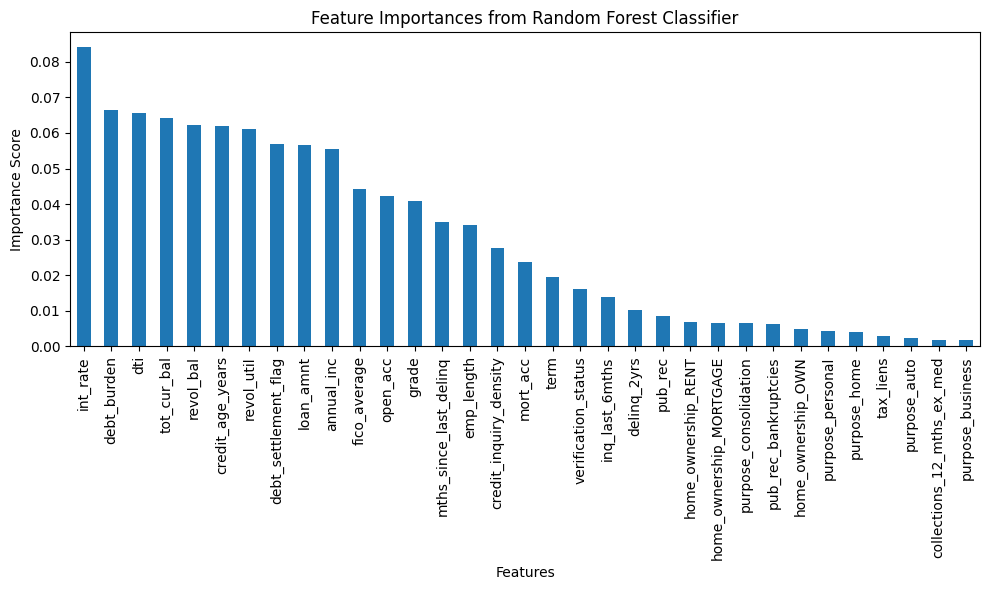

In [80]:
plt.figure(figsize=(10,6))
rf_clf_feat_imp.plot(kind='bar')
plt.title('Feature Importances from Random Forest Classifier')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

### SHAP

In [81]:
# Recreate the deprecated functions
if not hasattr(np, 'obj2sctype'):
    np.obj2sctype = lambda obj: np.dtype(obj).type
if not hasattr(np, 'issctype'):
    np.issctype = lambda obj: True

import shap
import fasttreeshap
X_small = shap.utils.sample(X_train_final_clf, nsamples=100000, random_state=42)
rf_clf_explainer = fasttreeshap.TreeExplainer(rf_clf, n_jobs=-1)
rf_clf_shap_vals = rf_clf_explainer.shap_values(X_small, approximate=True)

In [82]:
# Combine the matrices into a single one with shape (2*10000, 24)
all_shap_vals = np.vstack(rf_clf_shap_vals)  
# Create an index that repeats [0, 1] for each block of 10,000 rows
class_idx = np.repeat([0, 1], repeats=all_shap_vals.shape[0]//2)

rf_shapley_values_df = pd.DataFrame(
    all_shap_vals,
    columns=X_small.columns
)
rf_shapley_values_df.head()

,dti,inq_last_6mths,tot_cur_bal,revol_util,collections_12_mths_ex_med,pub_rec_bankruptcies,tax_liens,emp_length,mort_acc,mths_since_last_delinq,...,credit_inquiry_density,credit_age_years,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_auto,purpose_business,purpose_consolidation,purpose_home,purpose_personal
0,-0.031434,0.001680,-0.042683,-0.028171,-0.000364,-0.007501,-0.000046,-0.017646,0.001414,-0.008413,...,0.005943,0.017650,0.024267,0.006748,-0.010648,-0.000531,-0.000693,-0.001000,-0.000598,-0.001851
1,-0.031870,0.005062,-0.021371,-0.015977,-0.001592,-0.008509,0.000717,-0.031733,-0.034769,0.000793,...,0.008593,-0.027967,0.005876,0.003077,-0.001138,0.000866,-0.001027,-0.008330,0.000293,0.002282
2,-0.056174,-0.015561,-0.024743,-0.001632,-0.000021,-0.001026,0.000048,0.016012,-0.017289,-0.009108,...,-0.011717,-0.079864,0.016285,0.000511,0.025432,0.000025,-0.000443,0.002606,0.000455,-0.000158
3,0.007472,-0.001308,0.045077,0.018422,0.000143,0.001442,0.000793,0.053882,0.015238,-0.002846,...,-0.006924,0.027956,0.006048,0.005608,0.008689,-0.000053,0.060913,0.010424,0.001160,-0.001308
4,-0.024017,0.019667,0.012667,0.024464,0.000242,-0.000136,-0.004408,0.057717,-0.044917,0.039156,...,0.025518,0.082430,-0.011052,-0.001676,-0.005236,-0.000241,-0.000609,0.000448,0.000748,-0.001810


In [83]:
rf_clf_global_shap_values = np.abs(rf_shapley_values_df).mean()
rf_clf_global_shap_values = pd.DataFrame(rf_clf_global_shap_values, columns= ["SHAP"]).sort_values(by= "SHAP")
rf_clf_global_shap_values

,SHAP
collections_12_mths_ex_med,0.001133
purpose_auto,0.001310
purpose_business,0.001329
tax_liens,0.001778
purpose_home,0.002434
purpose_personal,0.002938
home_ownership_OWN,0.003064
purpose_consolidation,0.004007
pub_rec_bankruptcies,0.004115
pub_rec,0.004986


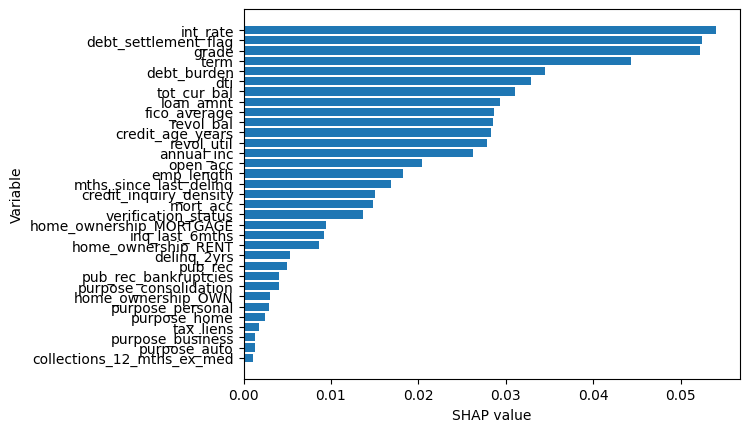

In [84]:
plt.barh(rf_clf_global_shap_values.index,rf_clf_global_shap_values["SHAP"])
plt.xlabel("SHAP value")
plt.ylabel("Variable")
plt.savefig("shap.png")

### Explainability by RGE

In [93]:
rge_df_clf = check_explainability.compute_rge_values(X_train_final_clf, X_test_final_clf, rf_clf_predicted_proba, rf_clf, list(X_test_final_clf.columns))
rge_df_clf.sort_values(by="RGE", ascending= True, inplace= True)
rge_df_clf

,RGE
collections_12_mths_ex_med,0.000072
purpose_auto,0.000143
tax_liens,0.000172
purpose_business,0.000214
purpose_home,0.000405
purpose_personal,0.000551
home_ownership_OWN,0.000714
pub_rec_bankruptcies,0.000848
purpose_consolidation,0.000975
delinq_2yrs,0.001204


In [94]:
# We want to check the explainability for home_ownership and purpose as group
explain_home_ownership = check_explainability.compute_rge_values(X_test_final_clf, X_test_final_clf, rf_clf_predited, rf_clf, ['home_ownership_OWN', 'home_ownership_RENT', 'home_ownership_MORTGAGE'], group= True)
explain_purpose = check_explainability.compute_rge_values(X_test_final_clf, X_test_final_clf, rf_clf_predited, rf_clf, ['purpose_business', 'purpose_auto', 'purpose_home', 'purpose_personal', 'purpose_consolidation'], group= True)

In [95]:
explain_home_ownership

,RGE
"['home_ownership_OWN', 'home_ownership_RENT', 'home_ownership_MORTGAGE']",0.004171


In [96]:
explain_purpose

,RGE
"['purpose_business', 'purpose_auto', 'purpose_home', 'purpose_personal', 'purpose_consolidation']",0.000323


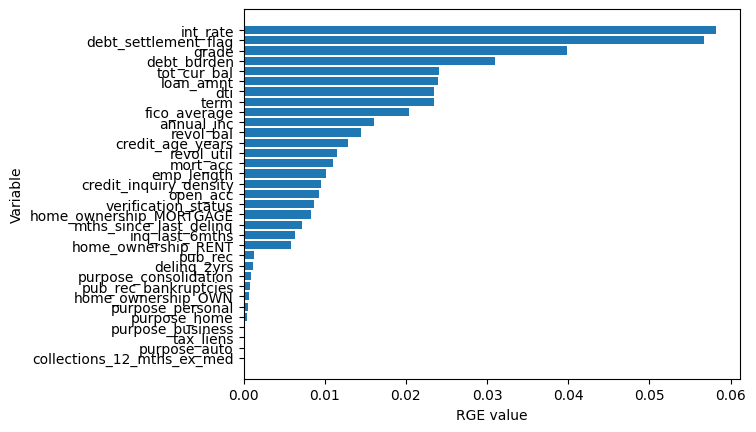

In [97]:
plt.barh(rge_df_clf.index, rge_df_clf["RGE"])
plt.xlabel("RGE value")
plt.ylabel("Variable")
plt.savefig("rge.png")

### Rubustness by RGR

In [98]:

# Compute_rgr_values is a function designed to measure robustness of the catboost classifier towards perturbations of
# the variables

check_robustness.compute_rgr_values(X_test_final_clf, rf_clf_predicted_proba, rf_clf, list(X_test_final_clf.columns))

,RGR
collections_12_mths_ex_med,0.999855
purpose_auto,0.999736
tax_liens,0.999649
purpose_business,0.999492
purpose_home,0.999461
purpose_consolidation,0.999437
home_ownership_OWN,0.999387
purpose_personal,0.999326
pub_rec_bankruptcies,0.999135
delinq_2yrs,0.998845
